# Introduction

We often implement ML models without considering their potential for harm. In this blog post we will be doing the opposite by examining how demographic bias can be learned by models. This post will explore how allocative bias on demographic factors can exist in models that are trained without access to said data! We will explore how to detect this bias and what its potential impact could be in a deployed model.

The code for the post is available at this [link](https://github.com/Nicholas-Sliter/middlebury-csci-0451/blob/main/posts/auditing-allocative-bias/index.ipynb).

We will use data from the `folktables` package which includes data from the American Community Survey’s Public Use Microdata Sample (PUMS). We will develop a classification model that uses demographic data to estimate if an individual's income is above a $50,000 threshold. We will then look for evidence of demographic based bias in the model's predictions. Specifically, we will withhold access to the binary `SEX` column and see if the resulting model has sex-based bias.

Documentation about the `folktables` package and the ACS data can be found [here](https://github.com/socialfoundations/folktables).



# Setup


Since I'm from Ohio, let's pull the ACS data from Ohio. This will allow us to work with a smaller dataset.

In [17]:
#| output: false
#| echo: false

from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#| output: false
#| echo: false

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)   
warnings.filterwarnings("ignore", category=ConvergenceWarning)   

In [19]:
STATE = "OH"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

Now the `acs_data` has a lot of columns. We will only be using a few of them for this post.

In [20]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
predictor = 'PINCP'
df = acs_data[[*possible_features, predictor]].copy()
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR,PINCP
0,82,12.0,2,16,1,NaN,1,1.0,4.0,1,1,2,2,1.0,2,2,6.0,19800.0
1,45,18.0,5,16,1,NaN,2,3.0,4.0,1,1,1,2,2.0,1,1,6.0,70000.0
2,50,14.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,1,1,1.0,26000.0
3,19,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,1,3.0,7400.0
4,18,18.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,1.0,600.0


Note: most of the features here are categorical factors. In these cases it may be preferable to switch to one-hot encoding. However, for this post we will be using the raw categorical factors.

# EDA

Let's begin by preliminarily exploring our data so we know what we are working with.  Consider the below correlation plot and observe the correlations with the `PINCP` column. 

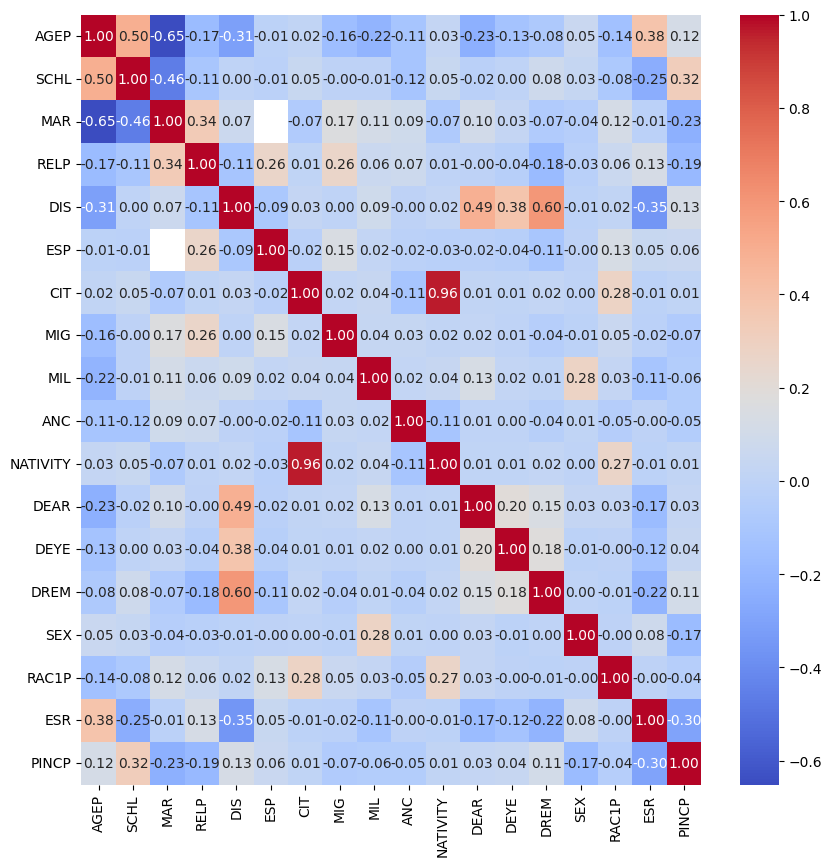

In [21]:
#| echo: false

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

It is clear to see features like `SCHL` (educational attainment), `MAR` (marital status) , `SEX` (binary sex), and `ESR` (employment status) are important. It is important to note that of these features, `SCHL` is ordinal but the other features are not. If we wanted a more robust model, we could convert the non-ordinal factors to one-hot encoding.

We might want to ask questions about the overall distribution of the data. These questions include:

1. How many people are in the dataset?
2. How many people make more than $50,000?

We can answer these questions by looking at the `PINCP` column.


In [22]:
num_rows = df.shape[0]

print(f"There are {num_rows} individuals in the dataset.")

num_gt_50000 = df[df["PINCP"] > 50000].shape[0]
print(f"There are {num_gt_50000} ({((num_gt_50000/num_rows)*100):.2f}%) individuals with income greater than $50,000.")


There are 119086 individuals in the dataset.
There are 23799 (19.98%) individuals with income greater than $50,000.


And we may also want to ask questions about the distribution of the data across different demographic factors. These questions include:

1. What is the demographic distribution of the dataset?
2. How many people in each demographic group make more than $50,000?

Let's answer these questions. We will start by looking at the distribution of the `SEX` column. Then we will group by `SEX` and look at the distribution of the `PINCP` column.

In [23]:
sex_df = df.copy()
sex_df["gt_50000"] = (sex_df["PINCP"] > 50000)*1

sex_df = sex_df.groupby("SEX").describe()["gt_50000"].reset_index()
sex_df["num_gt_50000"] = sex_df.apply(lambda row: row["count"]*row["mean"], axis=1)
sex_df

,SEX,count,mean,std,min,25%,50%,75%,max,num_gt_50000
0,1,58246.0,0.261134,0.439256,0.0,0.0,0.0,1.0,1.0,15210.0
1,2,60840.0,0.141174,0.348203,0.0,0.0,0.0,0.0,1.0,8589.0


This difference is very significant, while there are slightly more individuals of `SEX` 2 in our data, individuals of `SEX` 1 are almost 2x as likely to make more than $50,000. This is a very large difference and we should be concerned about it.

Our data is clearly biased in terms of `SEX`. But as we know, bias can be exacerbated by intersectional identities. Let's analyze the data against a combination of `SEX` and `RAC1P` (race).

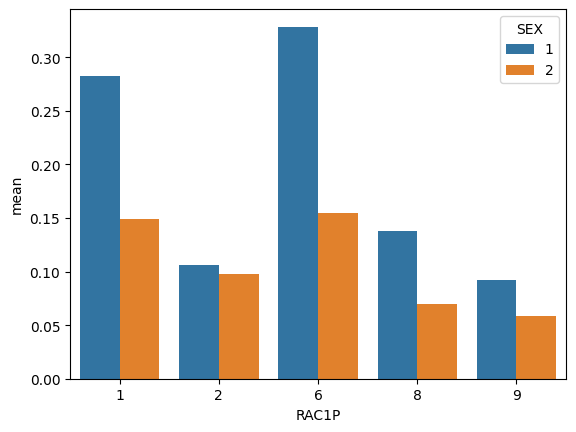

In [24]:
# intersectional analysis

sex_df = df.copy()
sex_df["gt_50000"] = (sex_df["PINCP"] > 50000)*1

sex_df = sex_df.groupby(["SEX", "RAC1P"]).describe()["gt_50000"].reset_index()
sex_df.sort_values("mean", ascending=False, inplace=True)
sex_df = sex_df.loc[sex_df["count"] > 100]

ax = sns.barplot(data=sex_df, x="RAC1P", y="mean", hue="SEX")

None # suppress output

This data shows extreme bias in income attainment threshold between both racial and sex groups. For example, individuals of `SEX` 1 and `RAC1P` 1 are 3x more likely to make more than $50,000 than individuals of `SEX` 2 and `RAC1P` 8. 

# Building our model

Now let's construct a `BasicProblem` to predict our target variable `PINCP` (income) and threshold from our features.

In [25]:
features_to_use = [f for f in possible_features if f not in ["SEX"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(df)

Now we will construct a pipeline to scale the data, generate interaction features, drop features with low variance, and then build a logistic regression model with optimized hyperparameters (using `LogisticRegressionCV`).

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

seed = 42

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features, label, group, test_size=0.2, random_state=seed) #stratify=group

model = make_pipeline(StandardScaler(),
                        PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
                        VarianceThreshold(),
                        LogisticRegressionCV(
                            Cs=10,
                            cv=5,
                            penalty='l2',
                            scoring='accuracy', # state of mind of company providing model is to maximize accuracy
                            random_state=seed,
                        )
                    )

model.fit(X_train, y_train)

print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))

Train score: 0.8408279800142755
Test score: 0.84364766143253


Our model performs well on both the training and test sets. This is a good sign for model performance and lack of overfitting. But this accuracy measure does not reveal any information about how decisions are made or the bias therein. Let's explore this further.

# Auditing our model

We will begin auditing our model by addressing:

1. Overall measures

2. Group measures

3. Bias measures


## Overall measures

We will start by looking at the overall measures of our model. These measures include:

1. Overall accuracy

2. Overall positive predictive value (PPV)

3. Overall false negative rate (FNR) and false positive rate (FPR)


In [27]:
from sklearn.metrics import precision_score, confusion_matrix

## Overall Measures

### What is the overall accuracy of your model?
print(f"Overall model accuracy: {model.score(X_test, y_test)}")

### What is the positive predictive value (PPV) of your model?
print(f"Model PPV is: {precision_score(y_test, model.predict(X_test))}")

### What are the overall false negative and false positive rates (FNR and FPR) for your model?
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
print(f"Model FNR is: {fn / (fn + tp)}")
print(f"Model FPR is: {fp / (fp + tn)}")


Overall model accuracy: 0.84364766143253
Model PPV is: 0.632495164410058
Model FNR is: 0.5112107623318386
Model FPR is: 0.06950614058008885


While our model's overall accuracy is quite high, it's false negative rate is very high. This means that our model is very likely to predict that an individual makes less than $50,000 when they actually make more than $50,000. This is likely due to class imbalances in the training data set. If we wanted to further optimize our model for the positive class, we could train on a balanced dataset or apply class weights. We will not do this for this post.

Let's now examine by group measures.

## Group measures

Now let's stratify our data by `SEX` and look at the above measures for each group.

In [28]:
## By-Group Measures

### What is the accuracy of your model on each subgroup? (Factors of SEX)
levels = np.unique(group_test)
accuracy = []
for sex in levels:
    subgroup_indices = group_test == sex
    subgroup_X_test = X_test[subgroup_indices]
    subgroup_y_test = y_test[subgroup_indices]
    acc = model.score(subgroup_X_test, subgroup_y_test)
    accuracy.append(acc)

    print(f"Model accuracy on sex {sex} is: {acc}")

max_diff = np.max(accuracy) - np.min(accuracy)
print(f"Max difference in accuracy between subgroups is: {max_diff}")

### What is the PPV of your model on each subgroup?
ppvs = []
for sex in levels:
    subgroup_indices = group_test == sex
    subgroup_X_test = X_test[subgroup_indices]
    subgroup_y_test = y_test[subgroup_indices]
    ppv = precision_score(subgroup_y_test, model.predict(subgroup_X_test))
    ppvs.append(ppv)

    print(f"Model ppv on sex {sex} is: {ppv}")

max_diff = np.max(ppvs) - np.min(ppvs)
print(f"Max difference in ppv between subgroups is: {max_diff}")

### What are the FNR and FPR on each subgroup?
fnrs = []
fprs = []

for sex in levels:
    subgroup_indices = group_test == sex
    subgroup_X_test = X_test[subgroup_indices]
    subgroup_y_test = y_test[subgroup_indices]
    tn, fp, fn, tp = confusion_matrix(subgroup_y_test, model.predict(subgroup_X_test)).ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    fnrs.append(fnr)
    fprs.append(fpr)

    print(f"Model FNR for sex {sex} is {fnr}")
    print(f"Model FPR for sex {sex} is {fpr}")

max_diff_fnr = np.max(fnrs) - np.min(fnrs)
max_diff_fpr = np.max(fprs) - np.min(fprs)
print(f"Max difference in FNR between subgroups is: {max_diff_fnr}")
print(f"Max difference in FPR between subgroups is: {max_diff_fpr}")

Model accuracy on sex 1 is: 0.8189293361884369
Model accuracy on sex 2 is: 0.8674133245491229
Max difference in accuracy between subgroups is: 0.048483988360686014
Model ppv on sex 1 is: 0.7455429497568882
Model ppv on sex 2 is: 0.5141402714932126
Max difference in ppv between subgroups is: 0.23140267826367555
Model FNR for sex 1 is 0.5434998346013894
Model FPR for sex 1 is 0.0544382801664355
Model FNR for sex 2 is 0.45240963855421684
Model FPR for sex 2 is 0.08194219212057617
Max difference in FNR between subgroups is: 0.09109019604717256
Max difference in FPR between subgroups is: 0.027503911954140668


Our model accuracy is very similar in each subgroup but our positive predictive value is much lower for `SEX` 2. This means that our model is much more likely to predict that an individual of `SEX` 2 makes more than $50,000 when they actually make less than $50,000.

## Bias Measures

1. Model calibration

2. Model error rate balance

3. Statistical parity

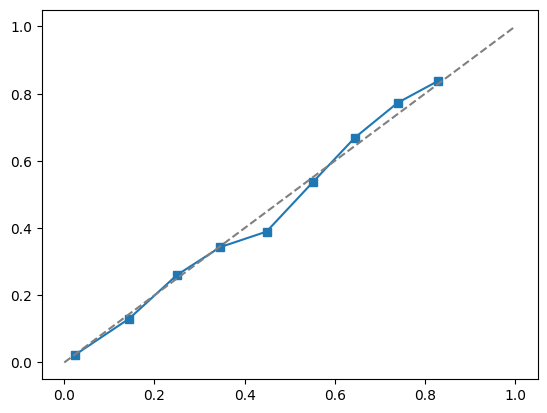

In [29]:
# Bias Measures

### Is your model approximately calibrated?
from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")


Our model is approximately calibrated as seen in the above graph.

In [30]:
# Does your model satisfy approximate error rate balance?

print(f"Max difference in FNR between subgroups is: {max_diff_fnr}")
print(f"Max difference in FPR between subgroups is: {max_diff_fpr}")

# It approximately satisfies FPR balance, but not FNR balance




# Does your model satisfy statistical parity?

positive_indices = y_test == 1

# proportion of positive predictions for each group
proportion_positive = []

for sex in levels:
     subgroup_indices = group_test == sex
     subgroup_positive_indices = np.logical_and(positive_indices, subgroup_indices)

     proportion_positive.append(np.sum(subgroup_positive_indices) / np.sum(subgroup_indices))

max_diff = np.max(proportion_positive) - np.min(proportion_positive)
print(f"Max difference in proportion of positive predictions between subgroups is: {max_diff}")


Max difference in FNR between subgroups is: 0.09109019604717256
Max difference in FPR between subgroups is: 0.027503911954140668
Max difference in proportion of positive predictions between subgroups is: 0.12222506212107292


Our model approximately balances error rates for FPR but not for FNR.

Our model does not have statistical parity given the large difference in the proportion of positive predictions between `SEX` groups.

# Concluding Discussion


### 1. What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial use?

A similar model would be beneficial for predictive industries like insurance providers and marketers. While the actual usefulness of this model is marginal at best due to the existence of census-level data and the fact that many of these companies would ask someone for their income directly, it could also be used at the individual level to try and predict future earning potential (e.g. for a student loan application, credit card application, or criminal sentencing).

### 2. Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?

I would expect the difference in sex subgroup PPV would cause the model to negatively impact real people. Using the above future prediction examples, it is clear to see that the degraded performance could impact loan acceptance, insurance rates and eligibility, access to financial institutions and credit cards, and could unfairly impact criminal sentencing. 


### 3. Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?

The model exhibits somewhat problematic bias in two ways: one, the max difference in FNR by sex subgroup is around ~9% which is large; and two, the max difference in PPV by sex subgroup is about 23% which is very large. In other measures, like calibration and overall accuracy by subgroup, the model performs well. Based on the difference in sex subgroup PPV alone, I would be hesitant in deploying this model for large-scale prediction in commercial or governmental settings. But the observed differences in model accuracy and PPV between subgroups also stands as evidence that sex is correlated with real-world income outcomes, and the model (which does not include the sex variable) does not have this context.

### 4. Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?

If this model were deployed in a production application I would worry about the downstream impact of the difference in model PPV by subgroup. The difference in PPV is large at ~23% and this would very easily lead to worse outcomes for certain subgroups. If for example, the model were deployed in predictive applications of insurance or similar industries (without access to the actual income) then it may lead to unfair rates or denial of service.